# Bayesian optimization (BO) with Gaussian process regression (GPR) with F3DASM

## 0. Goal of this notebook
This notebook serves to answer the following questions in order:
1. Which Python packages do I need to import in order to perform BO with GPR in F3DASM, and why?
2. What are the hyperparameters that BO with GPR uses and do I define them?
3. How do I run the BO algorithm?

## 1. Package dependencies

We first import the `f3dasm` library, which serves as the framework for doing BO with GPR.

In [1]:
import f3dasm

2023-03-09 11:28:18.257756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 11:28:18.395721: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-09 11:28:18.395746: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-09 11:28:19.102250: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


The BO pipeline in f3dasm is based on the `pytorch` framework. As such, we need to import these packages:

In [2]:
import torch, gpytorch

Lastly, we need to import the following packages to do the necessary intermediate math and visualization.

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## 2. Define the hyperparameters

As with the [GPR in f3dasm](./f3dasm_sogpr.ipynb) tutorial, we assume that there is a data source defined by an analytic function.

In [4]:
dimensionality = 1

fun = f3dasm.functions.Schwefel(
    dimensionality=dimensionality,
    scale_bounds=np.tile([0.0, 1.0], (dimensionality, 1)),
    )

2023-03-09 11:28:21.713214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 11:28:21.713509: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-03-09 11:28:21.713562: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2023-03-09 11:28:21.713607: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-03-09 11:28:21.713651: W tensorflow/compile

The goal is to minimize this objective function using Bayesian optimization.

### 2.1 GPR hyperparameters

In order for us to perform BO with GPR, we first need to specify the necessary hyperparameters of the GP regression model. 

This is done similarly in the way described in the GPR tutorial, so the details will be omitted here.

In [5]:
mean = gpytorch.means.ZeroMean()
kernel = gpytorch.kernels.ScaleKernel(base_kernel=gpytorch.kernels.RBFKernel())
likelihood = gpytorch.likelihoods.GaussianLikelihood()

opt_algo = torch.optim.Adam
opt_algo_kwargs = dict(lr=0.1)
training_iter = 50

noisy_data_bool = False
seed = 123

regressor_hyperparameters = f3dasm.machinelearning.gpr.Sogpr_Parameters(
    kernel=kernel,
    mean=mean,
    likelihood=likelihood,
    noise_fix=1 - noisy_data_bool,
    opt_algo=opt_algo,
    opt_algo_kwargs=opt_algo_kwargs,
    training_iter=training_iter,
    )

regressor = f3dasm.machinelearning.Sogpr

### 2.2 BO hyperparameters

Next, hyperparameters for the BO scheme are to be selected. These consist of two main parts:

1. The regressor class and corresponding hyperparameters;
2. The acquisition function class and corresponding hyperparameters.

The regressor has been taken care of in the previous code cell. For this tutorial, we will select the upper confidence bound acquisition function with the appropriate hyperparameters:

In [6]:
acquisition = f3dasm.base.acquisition.UpperConfidenceBound
acquisition_hyperparameters = f3dasm.optimization.bayesianoptimization_torch.Acquisition_Parameters(
    beta=0.4,
    maximize=False
)

https://distill.pub/2020/bayesian-optimization/

In addition to the regressor and acquisition related objects, a few other parameters are to be defined:

In [7]:
## Size of the initial design of experiments
n_init = 5

## Should the Bayesian optimizer plot the GP prediction at every iteration?
visualize_gp = False

## Number of iterations that BO should run for
iterations = 50

We can now combine the two parts into the optimizer parameter object:

In [8]:
opt_parameter = f3dasm.optimization.bayesianoptimization_torch.BayesianOptimizationTorch_Parameters(
    regressor=regressor,
    acquisition=acquisition,
    regressor_hyperparameters=regressor_hyperparameters,
    acquisition_hyperparameters=acquisition_hyperparameters,
    n_init=n_init,
    visualize_gp=visualize_gp,
)

## 3. Running BO

Before we can initialize the optimizer, we first need to identify the space and sampling method corresponding to the optimization problem.

In [9]:
parameter_DesignSpace = f3dasm.make_nd_continuous_design(
    bounds=np.tile([0.0, 1.0], (dimensionality, 1)),
    dimensionality=dimensionality,
)

sampler = f3dasm.sampling.SobolSequence(design=parameter_DesignSpace, seed=seed)

Now, the optimizer can be defined with the appropriate parameters.

In [10]:
optimizer = f3dasm.optimization.BayesianOptimizationTorch(
    data=f3dasm.ExperimentData(design=parameter_DesignSpace),
    )
optimizer.parameter = opt_parameter

Running the optimization scheme is then done as follows:

In [11]:
res = f3dasm.run_optimization(
    optimizer=optimizer,
    function=fun,
    sampler=sampler,
    iterations=iterations,
    seed=seed,
    number_of_samples=n_init,
)

## Scaling the data back to the true output values
res.data['output'] = optimizer.scaler.inverse_transform(res.data['output'])

We can now plot the optimization history of this optimization problem.

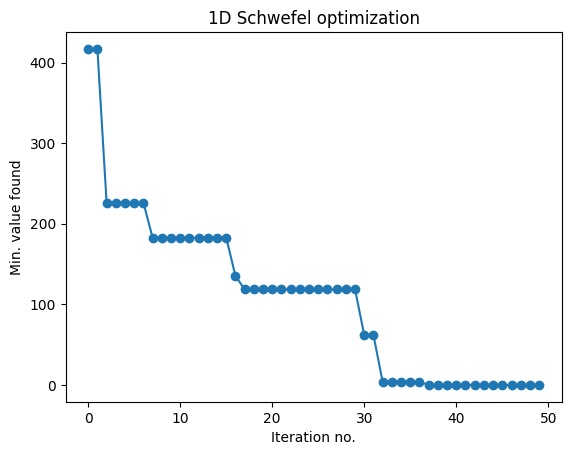

In [12]:
fig, ax = plt.subplots(1, 1)

ax.plot(res.data.cummin()['output'].values[n_init:], 'o-')

ax.set_title('1D ' + fun.name + ' optimization')

ax.set_xlabel('Iteration no.')

ax.set_ylabel('Min. value found')

plt.show()

In [13]:
fun.get_global_minimum(d=dimensionality) # ???

(array([[0.82253673]]), array([[669.66747537]]))